# Simple VAE on Faces Dataset

__Content of this notebook:__

    1) Reading and Exploring Data
    2) Designing the Neural Network and Training
    3) Visualizing Latent Space
    
__Dataset citation (http://vis-www.cs.umass.edu/lfw/part_labels/)__: *Kae, A., Sohn, K., Lee, H., Learned-Miller, E.: Augmenting CRFs with Boltzmann Machine Shape priors for image labeling. In: IEEE Conference on Computer Vision and Pattern Recognition (CVPR). (2013)*

<hr>
<hr>
<hr>

In [2]:
'''first importing libraries'''

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Flatten, Dense, Reshape
from keras import backend as K
import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt

### 1) Reading and Exploring Data

First, let's read __*masked_faces*__ dataset. This dataset contains masked face images.

In [3]:
faces = np.load('./data/masked_faces.npy').astype('float')/255 # reading data and normalized into range [0,1]

print(faces.shape) # printing shape

(2922, 128, 128, 3)


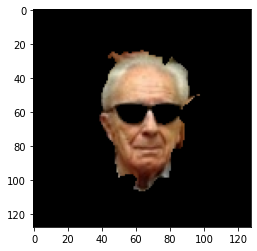

In [4]:
'''plot sample of the data'''

rand_idx = np.random.randint(0,faces.shape[0]) # generation of random index to choose random sample

plt.imshow(faces[rand_idx,:,:,:]) # plotting sample face
plt.show()

### 2) Designing the Neural Network and Training

In [6]:
'''Encoder Section'''

x_in = Input(shape=(128, 128, 3)) # input shape: (height, width, 3 bands)
x_temp = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Conv2D(16, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D(pool_size=(2, 2))(x_temp)
x_temp = Conv2D(16, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(16, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D(pool_size=(2, 2))(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D(pool_size=(2, 2))(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)

# flattening (converting from 2D to 1D), and adding Dense layers 
x_temp = Flatten()(x_temp)
x_temp = Dense(32, activation='relu')(x_temp)

'''Generating Latent Vector and Adding Gaussian Noise (Smoothing Latent Space)'''

x_latent = Dense(2, activation='linear')(x_temp) # 2 units corresponding to 2D latent space
x_latent_noise = GaussianNoise(0.5)(x_latent) # adding Gaussian Noise to Smooth Latent Space (this layer is only active in training time)

# increasing dimensionality of latent space with Dense layers and reshape into 2D
x_temp = Dense(32, activation='relu')(x_latent_noise)
x_temp = Dense(16*16*32, activation='relu')(x_temp)
x_temp = Reshape((16,16,32))(x_temp)

x_temp = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x_temp)
x_temp = Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(x_temp)
x_temp = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x_temp)
x_temp = Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(x_temp)
x_temp = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x_temp)
x_temp = Conv2DTranspose(16, (3,3), activation='relu', padding='same', strides=2)(x_temp)
x_temp = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x_temp)
x_temp = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x_temp)
x_out = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)

# custom loss function to calculate combined loss of reconstruction and latent space
def my_loss(true, pred):    
    
    # simple mean_squared_error reconstruction loss
    reconstruction_loss = keras.losses.mean_squared_error(K.flatten(true), K.flatten(pred))
    reconstruction_loss = reconstruction_loss * (128*128*3)
    # latent loss bringing latent space around origin (When latent vector moves away from origin, loss will he higher forcing latent space to distribute around origin)
    latent_loss = K.mean(K.flatten(K.square(x_latent)))
    
    return (reconstruction_loss + latent_loss)/2

model.compile(optimizer='adam', loss=my_loss) # setting loss and optimizer

model.summary() # printing the model summary

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0   

Here, neural network is designed as a simple encoder-decoder architecture. While encoder (down-sampling) consisted with convolutional and max pooling layers, decoder (up-sampling) consisted with transpose convolutional layers with and without strides.

In the middle, we have used Flatten, Reshape and Dense layers to generate 2D latent vectors. And simple Gaussian random noise is applied on latent vector to smooth the latent space eliminating complicated operations as in conventional VAEs. 

Schematic presentation of this idea is shown in following figure,

<img src="./graphics/Simple_VAEs.PNG" alt="Simple VAEs" width="60%"/>

And finally, loss is composed with 2 components
- Reconstruction loss: Mean Squared Loss of reconstruction of input images
- Latent loss (just the distance from origin): this forces latent space to distributing around the origin

In summary, applying simple Gaussian random noise on latent space with simple latent loss helps to generate smooth latent space as in conventional VAEs without complicated KL loss and sampling tricks.

In [7]:
'''training the model'''

fit_h = model.fit(faces, faces, epochs=200, batch_size=100, verbose=0, validation_split=0.3)

*Note: set verbose=1 to see training progress for each epoch. Single epoch takes 3s in single NVIDIA GTX 1080 Ti GPU.*

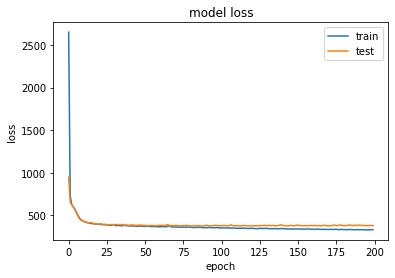

In [8]:
'''plotting loss curves'''

plt.plot(fit_h.history['loss'])
plt.plot(fit_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 3) Visualizing Latent Space

(2922, 2)


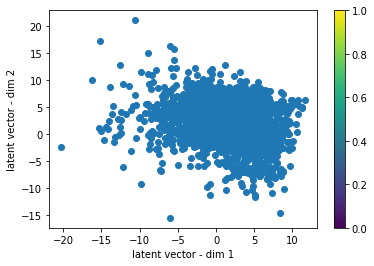

In [11]:
'''plotting latent space'''

# defining encoder model
model_enc = Model(x_in, x_latent)
latent_vec = model_enc.predict(faces)
print(latent_vec.shape)

# plotting latent 2D space as scatter plot
plt.scatter(latent_vec[:,0], latent_vec[:,1])
plt.xlabel('latent vector - dim 1')
plt.ylabel('latent vector - dim 2')
plt.colorbar()
plt.show()

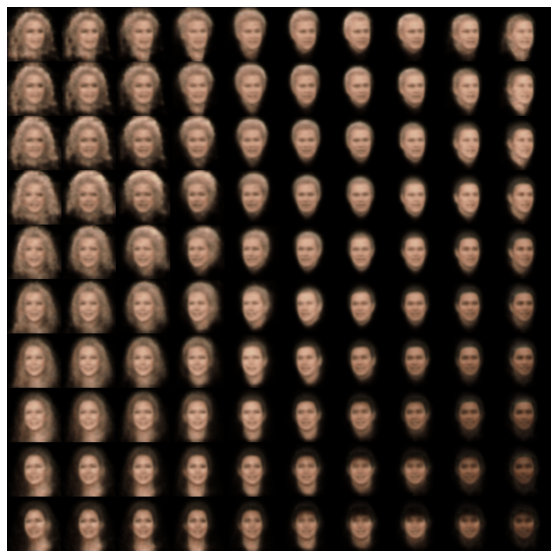

In [17]:
'''plotting generated images from latent space'''

# defining decoder model
gen_in = Input(shape=(1,2))
gen_temp = model.layers[16](gen_in)
gen_temp = model.layers[17](gen_temp)
gen_temp = model.layers[18](gen_temp)
gen_temp = model.layers[19](gen_temp)
gen_temp = model.layers[20](gen_temp)
gen_temp = model.layers[21](gen_temp)
gen_temp = model.layers[22](gen_temp)
gen_temp = model.layers[23](gen_temp)
gen_temp = model.layers[24](gen_temp)
gen_temp = model.layers[25](gen_temp)
gen_temp = model.layers[26](gen_temp)
gen_out = model.layers[27](gen_temp)
model_gen = Model(gen_in, gen_out)

# image generation and creating image from generated images
img_size = 128 # setting single image size
grid_x = np.linspace(-8, 8, 10) # setting min-max of latent space
grid_y = np.linspace(-8, 8, 10) # setting min-max of latent space
img_mat = np.zeros((grid_x.shape[0]*img_size, grid_y.shape[0]*img_size, 3))
for i1 in range(grid_x.shape[0]):
    for i2 in range(grid_y.shape[0]):
        sample_latent = np.array([grid_x[i1], grid_y[i2]]).reshape((1,1,2))
        img_mat[i1*img_size:i1*img_size+img_size, i2*img_size:i2*img_size+img_size, :] = model_gen.predict(sample_latent)
               
# showing generated images from latent space
plt.figure(figsize=(10, 10))
plt.imshow(img_mat)
plt.axis('off')
plt.show()